Pre-treatment data size before filtering: (480, 18)
Pre-treatment data size after filtering: (470, 18)
Post-treatment data size before filtering: (480, 18)
Post-treatment data size after filtering: (470, 18)
Weighted Pre-Treatment Speed: 17.08 mph
Weighted Post-Treatment Speed: 17.08 mph
T-Statistic: nan, P-Value: nan


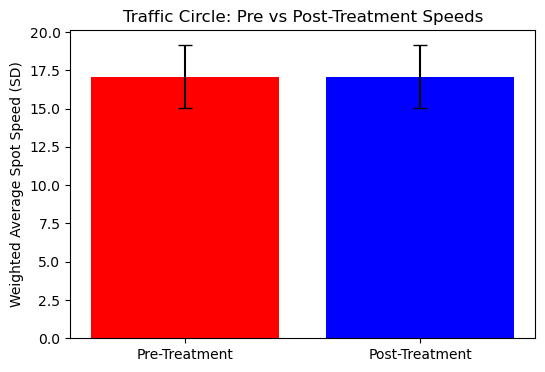

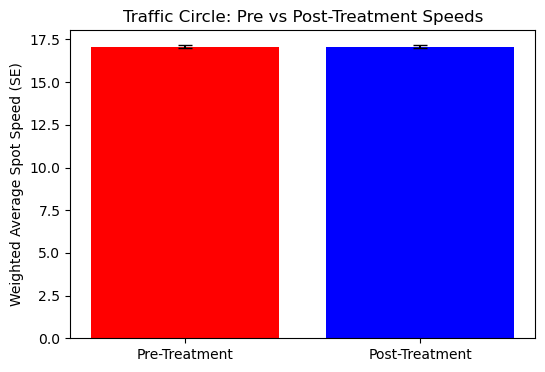

,Data Periods,Mode of Travel,Zone ID,Zone Name,Zone Is Pass-Through,Zone Direction (degrees),Zone is Bi-Direction,Year-Month,Day Type,Day Part,Average Daily Spot Traffic (StL Volume),Avg Spot Speed (mph),Free Flow Speed (mph),Free Flow Factor,5th Speed Percentile,15th Speed Percentile,85th Speed Percentile,95th Speed Percentile
133,"Jun 01, 2023 - Jun 01, 2024",All Vehicles - StL All Vehicles Volume,NaN,Avenue 50,yes,193,yes,2024-01,1: Weekday (M-Th),1: Early AM (12am-6am),11,15,17.108,0.890,11.0,12.0,20.0,36.0
14,"Jun 01, 2023 - Jun 01, 2024",All Vehicles - StL All Vehicles Volume,NaN,Avenue 50,yes,193,yes,2023-06,2: Weekend (Sa-Su),2: Peak AM (6am-10am),20,12,17.446,0.702,2.0,4.0,15.0,32.0
403,"Jun 01, 2023 - Jun 01, 2024",All Vehicles - StL All Vehicles Volume,NaN,Avenue 50 (1),yes,193,yes,2024-04,1: Weekday (M-Th),1: Early AM (12am-6am),12,14,16.292,0.852,7.0,10.0,20.0,31.0
745,"Jun 01, 2023 - Jun 01, 2024",All Vehicles - StL All Vehicles Volume,NaN,Stratford Road (1),yes,103,yes,2023-11,1: Weekday (M-Th),1: Early AM (12am-6am),35,20,21.896,0.916,15.0,16.0,23.0,30.0
122,"Jun 01, 2023 - Jun 01, 2024",All Vehicles - StL All Vehicles Volume,NaN,Avenue 50,yes,193,yes,2023-12,2: Weekend (Sa-Su),2: Peak AM (6am-10am),16,15,17.273,0.841,1.0,9.0,20.0,29.0
787,"Jun 01, 2023 - Jun 01, 2024",All Vehicles - StL All Vehicles Volume,NaN,Stratford Road (1),yes,103,yes,2024-01,2: Weekend (Sa-Su),1: Early AM (12am-6am),37,18,22.052,0.838,7.0,16.0,23.0,28.0
691,"Jun 01, 2023 - Jun 01, 2024",All Vehicles - StL All Vehicles Volume,NaN,Stratford Road (1),yes,103,yes,2023-08,1: Weekday (M-Th),1: Early AM (12am-6am),27,20,23.731,0.828,9.0,15.0,23.0,28.0
655,"Jun 01, 2023 - Jun 01, 2024",All Vehicles - StL All Vehicles Volume,NaN,Stratford Road (1),yes,103,yes,2023-06,1: Weekday (M-Th),1: Early AM (12am-6am),35,20,20.937,0.934,15.0,17.0,23.0,28.0
637,"Jun 01, 2023 - Jun 01, 2024",All Vehicles - StL All Vehicles Volume,NaN,Stratford Road,yes,103,yes,2024-05,1: Weekday (M-Th),1: Early AM (12am-6am),29,19,20.950,0.923,11.0,17.0,22.0,28.0
547,"Jun 01, 2023 - Jun 01, 2024",All Vehicles - StL All Vehicles Volume,NaN,Stratford Road,yes,103,yes,2023-12,1: Weekday (M-Th),1: Early AM (12am-6am),32,18,20.415,0.892,11.0,15.0,22.0,27.0


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

pre_treatment = pd.read_csv('data control/50_control_pre.csv')
post_treatment = pd.read_csv('data control/50_control_post.csv')

pre_filters = (pre_treatment['Day Type'] == '0: All Days (M-Su)') | (pre_treatment['Day Part'] == '0: All Day (12am-12am)')
post_filters = (post_treatment['Day Type'] == '0: All Days (M-Su)') | (post_treatment['Day Part'] == '0: All Day (12am-12am)')

pre_treatment = pre_treatment[~pre_filters]
post_treatment = post_treatment[~post_filters]

def filter_outliers(df, column, threshold=3):
    valid_values = df[column].dropna()
    z_scores = stats.zscore(valid_values)
    valid_indices = valid_values.index[np.abs(z_scores) < threshold]
    return df.loc[valid_indices]

pre_treatment_filtered = filter_outliers(pre_treatment, '95th Speed Percentile')
post_treatment_filtered = filter_outliers(post_treatment, '95th Speed Percentile')

print("Pre-treatment data size before filtering:", pre_treatment.shape)
print("Pre-treatment data size after filtering:", pre_treatment_filtered.shape)
print("Post-treatment data size before filtering:", post_treatment.shape)
print("Post-treatment data size after filtering:", post_treatment_filtered.shape)

pre_speeds = pre_treatment_filtered['Avg Spot Speed (mph)']
post_speeds = post_treatment_filtered['Avg Spot Speed (mph)']
pre_volume = pre_treatment_filtered['Average Daily Spot Traffic (StL Volume)']
post_volume = post_treatment_filtered['Average Daily Spot Traffic (StL Volume)']

pre_weighted_speed = (pre_speeds * pre_volume).sum() / pre_volume.sum()
post_weighted_speed = (post_speeds * post_volume).sum() / post_volume.sum()

def weighted_std(values, weights):
    mean = (values * weights).sum() / weights.sum()
    variance = (weights * (values - mean) ** 2).sum() / weights.sum()
    return variance ** 0.5

pre_weighted_std = weighted_std(pre_speeds, pre_volume)
post_weighted_std = weighted_std(post_speeds, post_volume)
pre_weighted_se = weighted_std(pre_speeds, pre_volume) / (len(pre_speeds) ** 0.5)
post_weighted_se = weighted_std(post_speeds, post_volume) / (len(post_speeds) ** 0.5)

valid_indices = pre_speeds.notna() & post_speeds.notna()
t_stat, p_value = stats.ttest_rel(pre_speeds[valid_indices], post_speeds[valid_indices])

print(f"Weighted Pre-Treatment Speed: {pre_weighted_speed:.2f} mph")
print(f"Weighted Post-Treatment Speed: {post_weighted_speed:.2f} mph")
print(f"T-Statistic: {t_stat:.3f}, P-Value: {p_value:.3f}")

bar_colors = ['red', 'blue']
plt.figure(figsize=(6, 4))
plt.bar(['Pre-Treatment', 'Post-Treatment'], 
        [pre_weighted_speed, post_weighted_speed], 
        yerr=[pre_weighted_std, post_weighted_std], capsize=5, color=bar_colors)
plt.ylabel('Weighted Average Spot Speed (SD)')
plt.title('Traffic Circle: Pre vs Post-Treatment Speeds')
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(['Pre-Treatment', 'Post-Treatment'], 
        [pre_weighted_speed, post_weighted_speed], 
        yerr=[pre_weighted_se, post_weighted_se], capsize=5, color=bar_colors)

plt.ylabel('Weighted Average Spot Speed (SE)')
plt.title('Traffic Circle: Pre vs Post-Treatment Speeds')
plt.show()

#max_85th_speed_row_pre = pre_treatment_filtered.loc[pre_treatment_filtered['85th Speed Percentile'].idxmax()]
#max_85th_speed_row_post = post_treatment_filtered.loc[post_treatment_filtered['85th Speed Percentile'].idxmax()]

#max_85th_speed_value_pre = max_85th_speed_row_pre['85th Speed Percentile']
#max_85th_speed_value_post = max_85th_speed_row_post['85th Speed Percentile']

#print(f"Highest value for pre-treatment'85th Speed Percentile': {max_85th_speed_value_pre} mph",
     #f"Highest value for post-treatment'85th Speed Percentile': {max_85th_speed_value_post} mph")
#print("Row details:")
#print(max_85th_speed_row_pre,max_85th_speed_row_post )
top_speed = pre_treatment.sort_values('95th Speed Percentile', ascending = False).head(10)
top_speed